Необходимо дополнить новыми метриками отчёт об эффективности рекламы в период с 11 июля по 10 августа 2020 года, подготовленный в предыдущей теме.

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


In [12]:
users = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_orders.csv')  # данные о покупках

In [13]:
# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

In [14]:
observation_date = users['dt'].max()  # момент анализа
analysis_horizon = 7  # горизонт анализа

In [17]:
ltv_raw, ltv, ltv_history = get_ltv(users, purchases, observation_date, analysis_horizon, dimensions=['channel']) # рассчитайте ltv с разбивкой по channel

plt.figure(figsize = (20, 5))  # размер сетки для графиков

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [18]:
plt.figure(figsize = (20, 5))  # размер сетки для графиков

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [19]:
# исключаем размеры когорт
report = ltv.drop(columns = ['cohort_size'])

Text(0.5, 0, 'Лайфтайм')

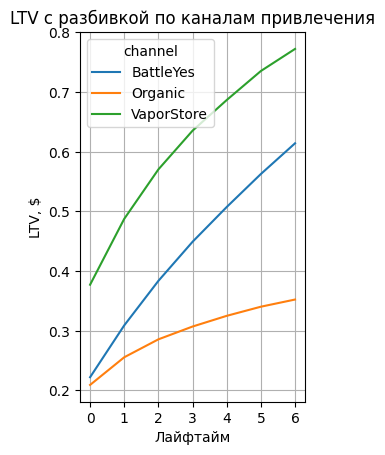

In [20]:
# в одной ячейке таблицы графиков построим кривые LTV
report.T.plot(grid=True,
             xticks=list(report.columns.values),
             ax=plt.subplot(1, 2, 1))
plt.title('LTV с разбивкой по каналам привлечения')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')

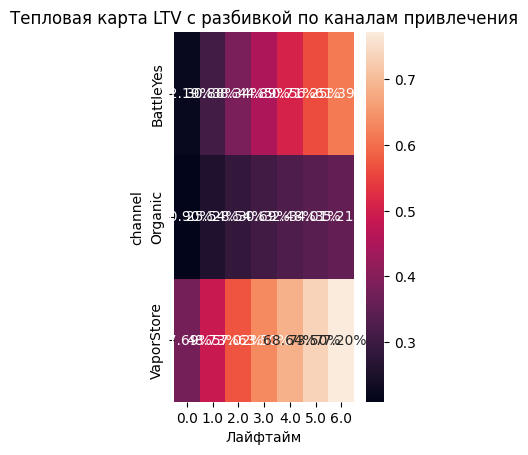

In [21]:
# в другой — хитмэп
sns.heatmap(report,
            annot=True,
            fmt='.2%',
            ax=plt.subplot(1, 2, 2))
plt.title('Тепловая карта LTV с разбивкой по каналам привлечения')
plt.xlabel('Лайфтайм')

plt.show()